###THIS IS THE CODE TO MOUNT GOOGLE DRIVE AND ACCESS DATA FROM THERE FOR RUNNING THE CODE

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##IMPORTING ALL REQUIRED LIBRARIES

In [200]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.regularizers import l1
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
from sklearn.decomposition import PCA

#**PART 1: DATA ANALYSIS FOR TRAINING**

###READING THE DATA FROM THE DRIVE

In [201]:
columns = ['unit_no', 'cycles', 'oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/train_FD003.txt"), sep ='\s+', header=None, names = columns)
df_test = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/test_FD003.txt"), sep ='\s+', header=None, names = columns)
df_RUL = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/RUL_FD003.txt"), sep ='\s+', header=None, names = ['RUL'])

In [202]:
df_train.isnull().sum()

unit_no    0
cycles     0
oc_1       0
oc_2       0
oc_3       0
s_1        0
s_2        0
s_3        0
s_4        0
s_5        0
s_6        0
s_7        0
s_8        0
s_9        0
s_10       0
s_11       0
s_12       0
s_13       0
s_14       0
s_15       0
s_16       0
s_17       0
s_18       0
s_19       0
s_20       0
s_21       0
dtype: int64

###*Hence, we see that the data is clean, has no NaN, nor does it have any blank cells.*



###The below line of code finds the maximum number of cycles each unit of engine takes until failure. This will be useful to make the "Remaining Useful Life" column

In [203]:
max_cycles_train = df_train.groupby(['unit_no'], sort=False)['cycles'].max().reset_index().rename(columns={'cycles':'MaxCycleID'})

###In the below cell, we are adding 2 new columns to the Dataframe, namely "MaxCycleID" and "RUL". "MaxCycleID" is the total number of cycles the unit took to fail. Then we subtract the number of cycles that have been performed, from the total number of cycles the unit took to fail.This gives the Remaining Useful Life, which is stored in the column "RUL".

In [204]:
df_train = pd.merge(df_train, max_cycles_train, how='inner', on='unit_no')
df_train['RUL'] = df_train['MaxCycleID'] - df_train['cycles']
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,MaxCycleID,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,259,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,259,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,259,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,259,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,259,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,152,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,152,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,152,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,152,1


In [205]:
print(np.max(np.array(df_train['MaxCycleID'])))

525


###Now we delete the column "MaxCycleID", since we have found the RUL.

In [97]:
df_train = df_train.drop(labels='MaxCycleID', axis=1)
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,1


###The column "RUL" is the column of values we want the model to predict. Also, the first 2 columns, "unit_no" and "cycles" don't play a role in prediction of "RUL". So we take all columns from 

In [98]:
df_train_x_split = df_train.iloc[:, 2:26]
df_train_x_split

,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


In [99]:
df_train_y = df_train.iloc[:, [26]]
df_train_y

,RUL
0,258
1,257
2,256
3,255
4,254
...,...
24715,4
24716,3
24717,2
24718,1


In [172]:
sc = StandardScaler()
df_train_x = sc.fit_transform(df_train_x_split)
print(df_train_x[0])
print(df_train_x[2])
df_train_y = sc.fit_transform(df_train_y)

[-0.21712243  1.34313474  0.          0.         -0.18710165 -0.71203753
 -0.780848   -1.          0.78158903 -0.34149389 -0.70478516 -0.09713812
 -0.35347902 -0.38560153 -0.22759327 -0.389857    0.06768652  0.46974107
 -1.         -0.88936355  0.          0.          0.48801891 -0.26351159]
[-0.62742556 -0.6974252   0.          0.         -0.53125638 -0.84125394
  0.11652408 -1.          0.78158903 -0.20766688 -0.26253575  0.3062675
 -0.35347902 -0.65220768 -0.31360822 -0.45310112  0.36155852 -0.10040895
 -1.         -0.88936355  0.          0.         -0.55674664 -0.17505798]


In [173]:
df_train_y = np.array(df_train_y)
df_train_y

array([[ 1.21324629],
       [ 1.20312941],
       [ 1.19301253],
       ...,
       [-1.37667569],
       [-1.38679258],
       [-1.39690946]])

Text(0, 0.5, 'Cumulative explained variance')

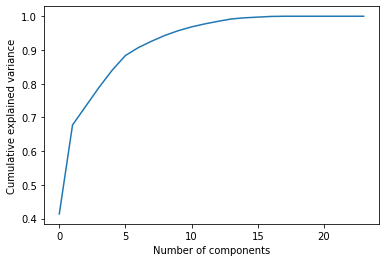

In [174]:
pca = PCA(n_components=24)
pca.fit(df_train_x)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [190]:
# define transform
pca = PCA(5)
# prepare transform on dataset
pca.fit(df_train_x)
# apply transform to dataset
df_train_x_reduced = pca.transform(df_train_x)


In [191]:
print(df_train_x_reduced)

[[-1.36627606 -0.37137675  1.33087338 -0.1366512  -0.34344741]
 [-0.89461299 -0.15861326 -0.9853303   0.27018494  0.35458906]
 [-1.05644698 -0.14708074 -0.53417255 -0.71950406  0.45669754]
 ...
 [ 1.5504916   6.7838461   1.23777087 -0.57885531 -0.62682071]
 [ 1.07762134  6.26843695  1.28387962 -0.90682552 -0.58384209]
 [ 1.54085335  6.26597798  0.86751352  0.12202447 -0.49961029]]


In [192]:
#Defining the model to be a Sequential Neural Network, by running the Sequential() constructor
model = Sequential()  
model.add(Dense(100,input_dim=5, activation='relu'))
# model.add(Dense(75 ,activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['mse'])
# model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mse'])


In [193]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_21 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 26        
Total params: 3,151
Trainable params: 3,151
Non-trainable params: 0
_________________________________________________________________


In [194]:
# es = EarlyStopping(monitor='val_mse', mode='min',patience=10, restore_best_weights = True) 
history = model.fit(df_train_x_reduced, df_train_y, batch_size=128, validation_split=0.2, epochs=75) #, callbacks=[es])

Epoch 1/75
155/155 [==============================] - 1s 3ms/step - loss: 0.4353 - mse: 0.4353 - val_loss: 0.5025 - val_mse: 0.5025
Epoch 2/75
155/155 [==============================] - 0s 2ms/step - loss: 0.3333 - mse: 0.3333 - val_loss: 0.5187 - val_mse: 0.5187
Epoch 3/75
155/155 [==============================] - 0s 3ms/step - loss: 0.3247 - mse: 0.3247 - val_loss: 0.4648 - val_mse: 0.4648
Epoch 4/75
155/155 [==============================] - 0s 2ms/step - loss: 0.3220 - mse: 0.3220 - val_loss: 0.4980 - val_mse: 0.4980
Epoch 5/75
155/155 [==============================] - 0s 2ms/step - loss: 0.3222 - mse: 0.3222 - val_loss: 0.4876 - val_mse: 0.4876
Epoch 6/75
155/155 [==============================] - 0s 2ms/step - loss: 0.3200 - mse: 0.3200 - val_loss: 0.4889 - val_mse: 0.4889
Epoch 7/75
155/155 [==============================] - 0s 3ms/step - loss: 0.3192 - mse: 0.3192 - val_loss: 0.4791 - val_mse: 0.4791
Epoch 8/75
155/155 [==============================] - 0s 2ms/step - loss: 0.

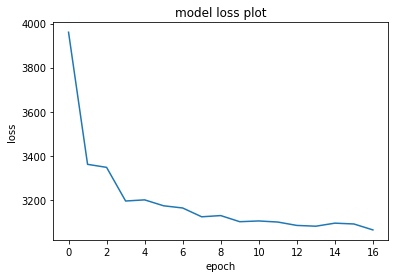

In [161]:
plt.plot(history.history['loss']) 
plt.title('model loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [198]:
test_data = df_train_x_reduced[4,:]
print(test_data)
print(model.predict(test_data.reshape(1,5), batch_size = 1))
print(df_train_y[24719])

[-0.61673065 -1.08151591 -0.025239    0.70936676  0.07709457]
[[0.4437816]]
[-1.39690946]


In [155]:
keras.backend.clear_session()